### Importing Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from langdetect import detect
from typing import List
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import re
from nltk.tokenize import RegexpTokenizer
import demoji
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import eli5
from sklearn.metrics import accuracy_score, classification_report

In [2]:
demoji.download_codes()

C:\Users\stabu\AppData\Local\Temp\ipykernel_14944\2299328559.py:1: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stabu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:

nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download("punkt")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stabu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\stabu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stabu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Importing dataset and First look

In [5]:
df = pd.read_csv("./data/Ukraine_10K_tweets_sentiment_analysis.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10167 entries, 0 to 10166
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tweet         9999 non-null   object 
 1   polarity      9999 non-null   float64
 2   subjectivity  9999 non-null   float64
 3   Sentiment     9999 non-null   object 
dtypes: float64(2), object(2)
memory usage: 317.8+ KB


In [7]:
df.head(5)

,Tweet,polarity,subjectivity,Sentiment
0,RT @ChristopherJM: Zelensky also confirms CIA ...,0.000000,0.000000,Negative
1,RT @oryxspioenkop: Russia acquired these vehic...,-0.100000,0.300000,Positive
2,RT @RepMTG: I’m calling for an audit of every ...,-0.035714,0.607143,Positive
3,"RT @KyivIndependent: ""Russian goal seems to be...",0.034091,0.113636,Negative
4,RT @william98161886: I see Rishi just given an...,-0.325521,0.166667,Positive


In [8]:
df.shape

(10167, 4)

In [9]:
df.size

40668

In [10]:
df.nunique()

Tweet           2744
polarity         246
subjectivity     232
Sentiment          2
dtype: int64

In [11]:
df['Sentiment'].value_counts()

Negative    7935
Positive    2064
Name: Sentiment, dtype: int64

In [12]:
# let's look at 2 positive reviews

for value in df.loc[df["Sentiment"] == "Positive"].head(2).Tweet.values:
    print(value)
    print()

RT @oryxspioenkop: Russia acquired these vehicles from the secondhand car market, and did not capture them from Ukraine. https://t.co/bagJE…

RT @RepMTG: I’m calling for an audit of every single penny that has been sent to Ukraine.

This must be done as soon as possible for the Am…



In [13]:
# let's look at 2 negative reviews

for value in df.loc[df["Sentiment"] == "Negative"].head(2).Tweet.values:
    print(value)
    print()

RT @ChristopherJM: Zelensky also confirms CIA Director Bill Burns' Kyiv visit Tuesday, during Russia's missile attack. “Yesterday Burns sat…

RT @KyivIndependent: "Russian goal seems to be to entrench and defend for the next several months, and then attempt a new offensive in the…



### Data cleaning 

##### Drop unused columns

In [14]:
df=df.drop(columns=["polarity","subjectivity"])

##### Remove dublicates

In [15]:
# remove dublicates
print(f"Size before: {df.size} {df.shape}")
df = df.drop_duplicates()
print(f"Size after: {df.size} {df.shape}")

Size before: 20334 (10167, 2)
Size after: 5490 (2745, 2)


In [16]:
#remove empty rows
print(f"Size before: {df.size} {df.shape}")
df.dropna()
print(f"Size after: {df.size} {df.shape}")

Size before: 5490 (2745, 2)
Size after: 5490 (2745, 2)


##### Remove non-english posts

In [17]:
def set_language(text: str) -> str:
    try:
        return detect(text)
    except:
        return "DELETE"

df['Language'] = df.Tweet.apply(set_language)

In [18]:
df['Language'].value_counts()

en        2083
fr         247
de         213
pl          35
DELETE      16
et          16
id          15
fa          13
ja          12
nl          10
uk           9
zh-cn        7
da           6
fi           6
tr           6
it           6
ru           6
af           5
no           4
hr           4
lt           3
tl           3
sk           2
vi           2
sw           2
ca           2
es           2
so           2
ro           2
ur           1
sl           1
bg           1
th           1
hi           1
cs           1
Name: Language, dtype: int64

In [19]:
df.drop(df.loc[df['Language']!="en"].index, inplace=True)

In [20]:
df=df.drop(columns=["Language"])

In [21]:
df.nunique()

Tweet        2083
Sentiment       2
dtype: int64

In [22]:
df['Sentiment'].value_counts()

Negative    1646
Positive     437
Name: Sentiment, dtype: int64

##### Save cleaned date to .csv

In [23]:
df.to_csv("./data/clean_tweets.csv",index=False)

### Plotting word clouds

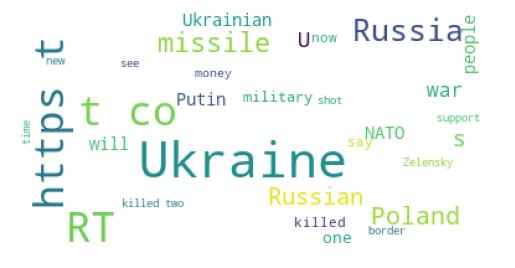

In [25]:
# looking at the cloud of postive reviews

postivie_df = df.loc[df["Sentiment"] == "Positive"]

all_tweets = " ".join(postivie_df["Tweet"].values)

#wordcloud = WordCloud().generate(all_tweets)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5).generate(all_tweets)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

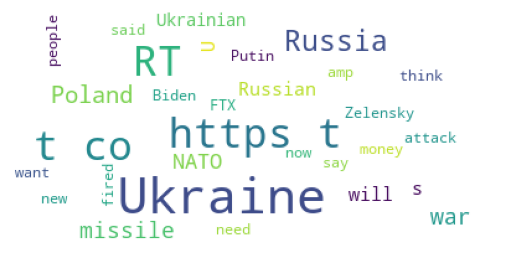

In [26]:
# looking at the cloud of negative reviews

negative_df = df.loc[df["Sentiment"] == "Negative"]

all_tweets = " ".join(negative_df["Tweet"].values)

wordcloud = WordCloud().generate(all_tweets)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=30,max_font_size=40, relative_scaling=.5).generate(all_tweets)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Preprocess Text and Count Vectorizer

In [27]:
df = pd.read_csv("./data/clean_tweets.csv")

##### Lower Casing

In [28]:
def lower_casing(text: str) -> str:
    return text.lower()

df["Tweet"] = df.Tweet.apply(lower_casing)

cv = CountVectorizer()
cv.fit(df["Tweet"].values)

print("dictionary size: ", len(cv.get_feature_names_out()))
print(df.head(2).Tweet.values)

dictionary size:  7860
["rt @christopherjm: zelensky also confirms cia director bill burns' kyiv visit tuesday, during russia's missile attack. “yesterday burns sat…"
 'rt @oryxspioenkop: russia acquired these vehicles from the secondhand car market, and did not capture them from ukraine. https://t.co/bagje…']


##### Replacing URLs

In [29]:
def URL_relpacing(text: str) -> str:
    return re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)","URL", text)

df["Tweet"] = df.Tweet.apply(URL_relpacing)

cv = CountVectorizer()
cv.fit(df["Tweet"].values)

print("dictionary size: ", len(cv.get_feature_names_out()))
print(df.head(2).Tweet.values)


dictionary size:  6952
["rt @christopherjm: zelensky also confirms cia director bill burns' kyiv visit tuesday, during russia's missile attack. “yesterday burns sat…"
 'rt @oryxspioenkop: russia acquired these vehicles from the secondhand car market, and did not capture them from ukraine. URL']


##### Removing Usernames

In [31]:
def User_remove(text: str) -> str:
    return re.sub('@[^\s]+',"", text)
    
df["Tweet"] = df.Tweet.apply(User_remove)

cv = CountVectorizer()
cv.fit(df["Tweet"].values)

print("dictionary size: ", len(cv.get_feature_names_out()))
print(df.head(2).Tweet.values)

dictionary size:  5379
["rt  zelensky also confirms cia director bill burns' kyiv visit tuesday, during russia's missile attack. “yesterday burns sat…"
 'rt  russia acquired these vehicles from the secondhand car market, and did not capture them from ukraine. URL']


##### Replacing Emojis

In [33]:
def Replacing_emojis(text: str) -> str:
    return demoji.replace_with_desc(text,"")
    
df["Tweet"] = df.Tweet.apply(Replacing_emojis)

cv = CountVectorizer()
cv.fit(df["Tweet"].values)

print("dictionary size: ", len(cv.get_feature_names_out()))
print(df.head(2).Tweet.values)


dictionary size:  5512
["rt  zelensky also confirms cia director bill burns' kyiv visit tuesday, during russia's missile attack. “yesterday burns sat…"
 'rt  russia acquired these vehicles from the secondhand car market, and did not capture them from ukraine. URL']


##### Removing stopwords


In [34]:
tokenizer = RegexpTokenizer ("\w+")

In [35]:
def remove_stop_words(text: str) -> str:
    stop_words = set(stopwords.words("english"))
    words = tokenizer.tokenize(text)
    return " ".join([word for word in words if word not in stop_words])

df["Tweet"] = df.Tweet.apply(remove_stop_words)

cv = CountVectorizer()
cv.fit(df["Tweet"].values)

print("dictionary size: ", len(cv.get_feature_names_out()))
print(df.head(100).Tweet.values)
    

dictionary size:  5379
['rt zelensky also confirms cia director bill burns kyiv visit tuesday russia missile attack yesterday burns sat'
 'rt russia acquired vehicles secondhand car market capture ukraine URL'
 'rt calling audit every single penny sent ukraine must done soon possible'
 'rt russian goal seems entrench defend next several months attempt new offensive'
 'rt see rishi given another 4 half billion ukraine think us fekin war russia'
 'rt URL'
 'rt predicting trajectory pacing war america strong suit providing security assistance le'
 'rt putin took ukraine guarantee immediately little go neighbo'
 'risk spillover ukraine war contained URL'
 'rt biden ftx ukraine everything claimed trump russia investigated five straight ye'
 'canada sanctions iranian drone makers amid russian strikes ukraine national iranrussiannews russiannews URL'
 'rt three military toyota mega cruisers likely donated ukraine japan russian service URL'
 'rt freedom democracy arrived kherson sbu security s

##### Lemmatizing and Stemmerizing 


In [36]:
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer ("\w+")

In [38]:
df["Tweet"] = df.Tweet.apply(lambda x: " ".join([stemmer.stem(lemmatizer.lemmatize(i)) for i in tokenizer.tokenize(x)]))

cv = CountVectorizer(stop_words=["english"])

cv.fit(df["Tweet"].values)
print("dictionary size: ", len(cv.get_feature_names_out()))

print("dictionary: ", cv.get_feature_names_out())
df.shape
print(df.head(20).Tweet.values)

dictionary size:  4163
dictionary:  ['00' '000' '02' ... 'สเซ' 'เครน' '❼11']
['rt zelenski also confirm cia director bill burn kyiv visit tuesday russia missil attack yesterday burn sat'
 'rt russia acquir vehicl secondhand car market captur ukrain url'
 'rt call audit everi singl penni sent ukrain must done soon possibl'
 'rt russian goal seem entrench defend next sever month attempt new offen'
 'rt see rishi given anoth 4 half billion ukrain think u fekin war russia'
 'rt url'
 'rt predict trajectori pace war america strong suit provid secur assist le'
 'rt putin took ukrain guarant immedi littl go neighbo'
 'risk spillov ukrain war contain url'
 'rt biden ftx ukrain everyth claim trump russia investig five straight ye'
 'canada sanction iranian drone maker amid russian strike ukrain nation iranrussiannew russiannew url'
 'rt three militari toyota mega cruiser like donat ukrain japan russian servic url'
 'rt freedom democraci arriv kherson sbu secur servic ukrain round collabor'
 'rt

### Write Text Transformer

In [39]:
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        self._tokenizer = RegexpTokenizer("\w+")
        self._stemmer = SnowballStemmer("english")
        self._lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y = None):
        return self

    def _lower_casing(self, text: str) -> str:
        return text.lower()  

    def _URL_relpacing(self, text: str) -> str:
        return re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)","URL", text) 
    
    def _User_remove(self, text: str) -> str:
        return re.sub('@[^\s]+',"", text)

    def _replacing_emojis(self, text: str) -> str:
        return demoji.replace_with_desc(text,"")
    
    def _remove_stop_words(self, text: str) -> str:
        stop_words = set(stopwords.words("english"))
        words = self._tokenizer.tokenize(text)
        return " ".join([word for word in words if word not in stop_words])
    
    def _transform_text(self, text: str) -> str:
        text = self._lower_casing(text)
        text = self._URL_relpacing(text)
        text = self._User_remove(text)
        text = self._replacing_emojis(text)
        text = self._remove_stop_words(text)
        words = self._tokenizer.tokenize(text)
        return " ".join([self._stemmer.stem(self._lemmatizer.lemmatize(word)) for word in words])
    
    def transform(self, X: List[str], y = None) -> List[str]:
        return [self._transform_text(x) for x in X]

In [40]:
text_transformer = TextTransformer()

##### How transformer works

In [41]:
df = pd.read_csv("./data/clean_tweets.csv")
print(df.head(2)["Tweet"].values)
text_transformer.fit_transform(df.head(2)["Tweet"].values)

["RT @ChristopherJM: Zelensky also confirms CIA Director Bill Burns' Kyiv visit Tuesday, during Russia's missile attack. “Yesterday Burns sat…"
 'RT @oryxspioenkop: Russia acquired these vehicles from the secondhand car market, and did not capture them from Ukraine. https://t.co/bagJE…']


['rt zelenski also confirm cia director bill burn kyiv visit tuesday russia missil attack yesterday burn sat',
 'rt russia acquir vehicl secondhand car market captur ukrain url']

### Pipeline

In [42]:
pipeline = Pipeline([
    ("text_preprocessor", TextTransformer()),
    ("cv", CountVectorizer(stop_words=["english"])),
    ("model", LogisticRegression())
])

In [43]:
df = pd.read_csv("./data/clean_tweets.csv")
df["label"] = df["Sentiment"].apply(lambda x: int(x == "Positive"))

print (df.groupby(by=["label"]).size())
df.head(5)

label
0    1646
1     437
dtype: int64


,Tweet,Sentiment,label
0,RT @ChristopherJM: Zelensky also confirms CIA ...,Negative,0
1,RT @oryxspioenkop: Russia acquired these vehic...,Positive,1
2,RT @RepMTG: I’m calling for an audit of every ...,Positive,1
3,"RT @KyivIndependent: ""Russian goal seems to be...",Negative,0
4,RT @william98161886: I see Rishi just given an...,Positive,1


### Train

In [44]:
train_df, test_df = train_test_split(df)

print ("Train:",train_df.groupby(by=["label"]).size())
print ("Test:", test_df.groupby(by=["label"]).size())

Train: label
0    1243
1     319
dtype: int64
Test: label
0    403
1    118
dtype: int64


In [45]:
pipeline.fit(train_df["Tweet"].values, train_df["label"].values)

Pipeline(steps=[('text_preprocessor', TextTransformer()),
                ('cv', CountVectorizer(stop_words=['english'])),
                ('model', LogisticRegression())])

In [46]:
y_true = test_df["label"].values

predictions = pipeline.predict(test_df["Tweet"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
#print(classification_report(y_true, predictions))

Accuracy:  0.8080614203454894


In [47]:
feature_names = pipeline.named_steps["cv"].get_feature_names_out()
feature_names

array(['00', '000', '02', ..., 'สเซ', 'เครน', '❼11'], dtype=object)

In [49]:
eli5.explain_weights(pipeline.named_steps["model"],top=100, feature_names=feature_names)



Weight?,Feature
+2.378,militari
+1.901,fals
+1.747,dead
+1.690,wrong
+1.579,bad
+1.573,tough
+1.507,sorri
+1.502,illeg
+1.500,stupid
+1.497,corrupt


In [50]:
#eli5.show_prediction("RT @jacksonhinklle: I was called a dangerous conspiracy theorist yesterday for stating that Ukraine was responsible for the deadly missileâ€¦",text) 